# Homework 6

## Problem 1

We just expand the expression

$$
\begin{aligned}
-b_{\kappa\Sigma_t}(h_t, y_t) &= -\frac{1}{2}(h_t-y_t)'\kappa\Sigma_t(h_t-y_t)\\
                              &= -\frac{1}{2}\kappa y_t'\Sigma_t y_t + \kappa h_t'\Sigma_t y_t h - \frac{1}{2}h_t'(\kappa\Sigma_t) h_t\\
                              &= O(y^2) + h_t' \alpha_t - \frac{1}{2}h_t'(\kappa\Sigma_t) h_t\\
\end{aligned}
$$

as we can see from this expression, $b_{\kappa\Sigma_t}(h_t, y_t)$ is a convex function on $h_t$

## Problem 2

In [1]:
import numpy as np
from scipy.optimize import minimize
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class OptimalTrading:

    def __init__(self, T, P, V, Theta, sigma, gamma, eta, beta, kappa, t_half, alpha_init):
        self.T = T
        self.P = P
        self.V = V
        self.Theta = Theta
        self.sigma = sigma
        self.gamma = gamma
        self.eta = eta
        self.beta = beta
        self.kappa = kappa
        self.t_half = t_half
        self.alpha_init = alpha_init

    def Tcost(self, delta):
        
        '''
        
        T-cost function following Almgren
        
        '''
        
        X = delta / self.P

        term1 = 0.5 * self.gamma * self.sigma * \
            X / self.V * ((self.Theta/self.V) ** 0.25)
        
        term2 = np.sign(X) * self.eta * self.sigma * (abs(X/self.V) ** self.beta)
        
        return self.P * X * (term1 + term2)
    
    def alpha(self, t):
        '''
        forecast is 50 basis points with 5 days half-life
        '''
        return self.alpha_init * 1e-4 * (2 ** (-t/self.t_half))
    
    def u(self, x):
        
        '''
        utility function
        '''
        
        res = 0.0
        
        for t in range(1, 1+self.T):
            
            res += x[t] * self.alpha(t) \
                   - 0.5 * self.kappa * ((self.sigma * x[t]) ** 2) \
                   - self.Tcost(delta=x[t]-x[t-1])
            
        return res
    
    def coordinate_descent(self, epoch=5, disable_progress=False):
        
        # we take index from 1 to T as our result
        delta = np.full(self.T+1, self.P / self.T)
        delta[0] = 0
        
        for i in range(epoch):
            
            loop = tqdm(range(1, 1+self.T), disable=disable_progress, leave=False)
            x_prev = delta.cumsum()
            
            # fix all delta except for delta_t
            for t in loop:
            
                def obj(delta_t):
                    delta[t] = delta_t
                    x = delta.cumsum()
                    return -self.u(x)
                
                # Powell algo can find a local minimum
                # since our obj function is convex
                # local minimum is global minimum
                # Powell doesn't require gradient of objective
                # so we choose this algorithm
                res = minimize(obj, x0=0, method='Powell')
                delta[t] = res.x[0]
                
                loop.set_description(f"Epoch [{i}/{epoch}]")
                loop.set_postfix(u = -res.fun)
                
            # Set tolerance so that your algorithm does not terminate 
            # unless each xt ∈ R is within a distance of one dollar 
            # to the true optimal path.
            x_new = delta.cumsum()
            max_dx = np.max(np.abs(x_new-x_prev))
            
            if max_dx < 1:
                break
               
        self.x = delta.cumsum()
        self.delta = delta
        return self.x
    
    def profit(self):
        
        r = np.array([self.alpha(t) for t in range(1+self.T)])
        pi = np.dot(x, r) - np.sum([self.Tcost(d) for d in self.delta])
        
        return pi
    
    def variance(self):
        
        return (self.sigma ** 2) * np.sum(x ** 2)

    def sharpe(self):
        
        return np.sqrt(252) * self.profit() / np.sqrt(self.variance())
    
    
            

opt_trade = OptimalTrading(T=30, P=40, V=2e6, Theta=2e8, sigma=2e-2, gamma=0.314, 
                           eta=0.142, beta=0.6, kappa=1e-7, alpha_init=50, t_half=5.0)

(a) Find the sequence of positions.

The following code will optimize the trading plan. As we can see from the timing cell, it took 17s.

In [3]:
%time x = opt_trade.coordinate_descent(epoch=50000)

CPU times: user 16 s, sys: 995 ms, total: 17 s
Wall time: 18.3 s


Plot the optimal path.

Text(0, 0.5, 'dollar position')

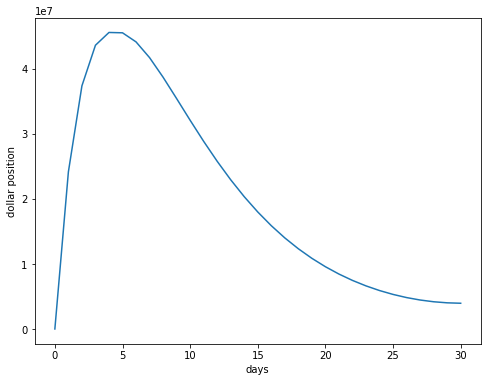

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x)
ax.set_xlabel('days')
ax.set_ylabel('dollar position')

report its values in a table.

In [5]:
print(x)

[       0.         24160650.08397392 37387265.33129665 43628840.24391901
 45593530.15001899 45541223.58827333 44144891.65795309 41725098.16966084
 38711903.55075526 35427859.87168082 32093129.35834883 28849449.7443338
 25782412.14885559 22938856.24946681 20339651.50525384 17988797.30934352
 15879778.38318802 13999935.55167019 12333430.0352212  10863234.39388571
  9572443.14061395  8445137.24210925  7466944.99405821  6625404.82926145
  5910199.10613426  5313287.9547689   4828936.23559275  4453549.85988613
  4185142.34944677  4021385.3028695   3955879.24665389]


(b) Use the program you wrote in part (a) to plot expected profit of the optimal path and ex ante Sharpe ratio of the optimal path as a function of κ, as a function of the half-life (which was taken to be 5 in equation (0.1) above), as a function of the initial strength (taken to be 50 in equation (0.1)), and as a function of σ. 

In [6]:
S_vs_kappa = []
S_vs_t_half = []
S_vs_alpha = []
S_vs_sigma = []
pi_vs_kappa = []
pi_vs_t_half = []
pi_vs_alpha = []
pi_vs_sigma = []

kappas = np.arange(1e-8, 2e-7, 2e-8)
t_halfs = np.arange(1, 10, 1)
alphas = np.arange(30, 80, 5)
sigmas = np.arange(0.01, 0.03, 0.001)

In [7]:
for kappa in tqdm(kappas):
    opt_trade = OptimalTrading(T=30, P=40, V=2e6, Theta=2e8, sigma=2e-2, gamma=0.314, 
                           eta=0.142, beta=0.6, kappa=kappa, alpha_init=50, t_half=5.0)
    opt_trade.coordinate_descent(epoch=5000, disable_progress=True);
    S_vs_kappa.append(opt_trade.sharpe())
    pi_vs_kappa.append(opt_trade.profit())

100%|██████████| 10/10 [04:47<00:00, 28.71s/it]


In [8]:
for t_half in tqdm(t_halfs):
    opt_trade = OptimalTrading(T=30, P=40, V=2e6, Theta=2e8, sigma=2e-2, gamma=0.314, 
                           eta=0.142, beta=0.6, kappa=1e-7, alpha_init=50, t_half=t_half)
    opt_trade.coordinate_descent(epoch=5000, disable_progress=True);
    S_vs_t_half.append(opt_trade.sharpe())
    pi_vs_t_half.append(opt_trade.profit())

100%|██████████| 9/9 [01:49<00:00, 12.19s/it]


In [9]:
for alpha in tqdm(alphas):
    opt_trade = OptimalTrading(T=30, P=40, V=2e6, Theta=2e8, sigma=2e-2, gamma=0.314, 
                           eta=0.142, beta=0.6, kappa=1e-7, alpha_init=alpha, t_half=5.0)
    opt_trade.coordinate_descent(epoch=5000, disable_progress=True);
    S_vs_alpha.append(opt_trade.sharpe())
    pi_vs_alpha.append(opt_trade.profit())

100%|██████████| 10/10 [02:48<00:00, 16.88s/it]


In [10]:
for sigma in tqdm(sigmas):
    opt_trade = OptimalTrading(T=30, P=40, V=2e6, Theta=2e8, sigma=sigma, gamma=0.314, 
                           eta=0.142, beta=0.6, kappa=1e-7, alpha_init=50, t_half=5.0)
    opt_trade.coordinate_descent(epoch=5000, disable_progress=True);
    S_vs_sigma.append(opt_trade.sharpe())
    pi_vs_sigma.append(opt_trade.profit())

100%|██████████| 20/20 [04:25<00:00, 13.25s/it]


Text(0, 0.5, 'Sharpe$(x^*)$')

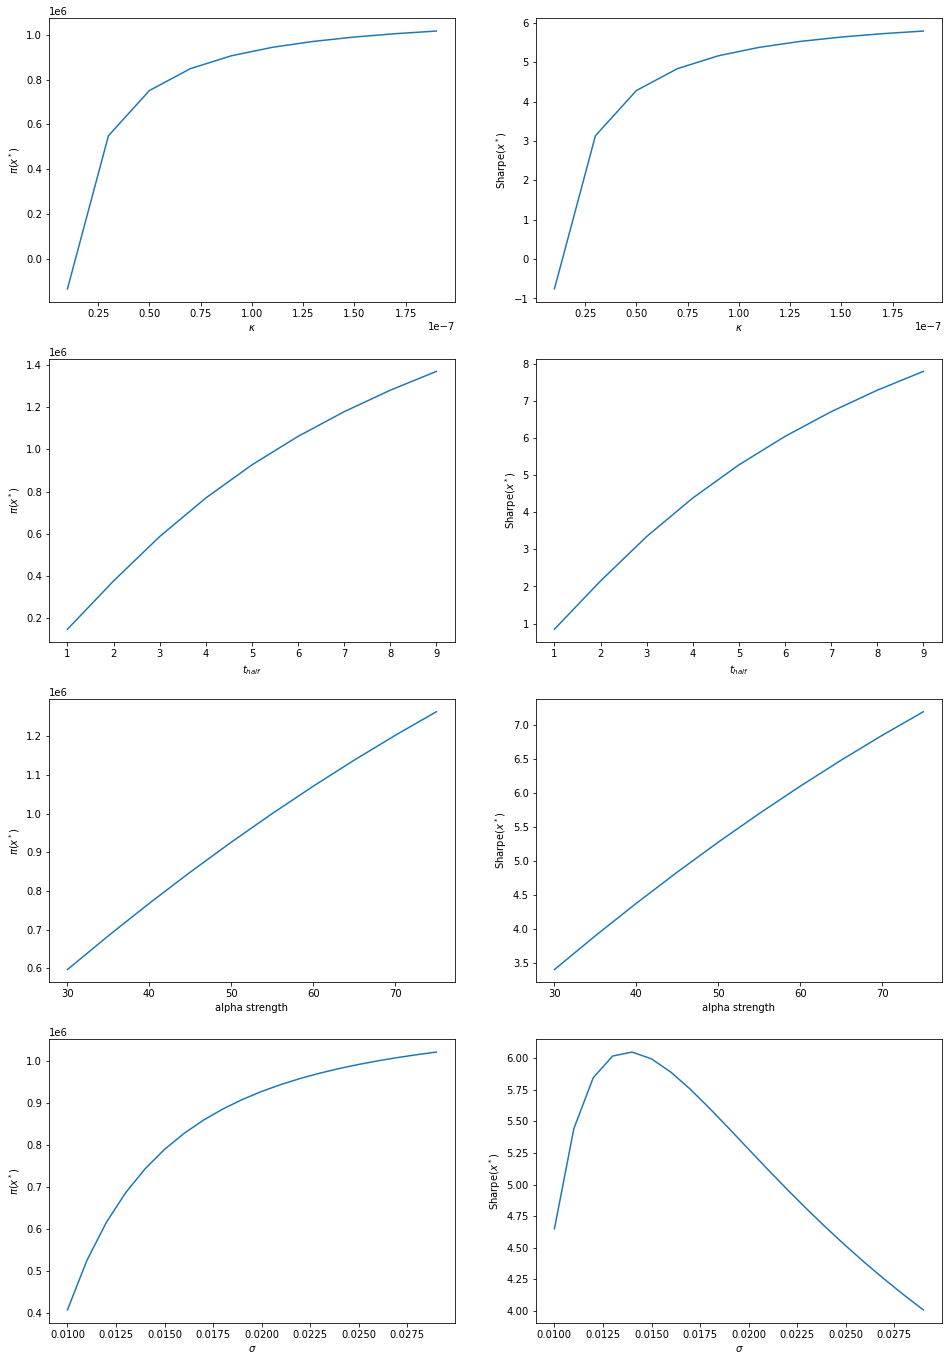

In [11]:
fix, axes = plt.subplots(4, 2, figsize=(16, 24))

axes[0][0].plot(kappas, pi_vs_kappa)
axes[0][0].set_xlabel('$\kappa$')
axes[0][0].set_ylabel('$\pi(x^*)$')
axes[0][1].plot(kappas, S_vs_kappa)
axes[0][1].set_xlabel('$\kappa$')
axes[0][1].set_ylabel('Sharpe$(x^*)$')

axes[1][0].plot(t_halfs, pi_vs_t_half)
axes[1][0].set_xlabel('$t_{half}$')
axes[1][0].set_ylabel('$\pi(x^*)$')
axes[1][1].plot(t_halfs, S_vs_t_half)
axes[1][1].set_xlabel('$t_{half}$')
axes[1][1].set_ylabel('Sharpe$(x^*)$')

axes[2][0].plot(alphas, pi_vs_alpha)
axes[2][0].set_xlabel('alpha strength')
axes[2][0].set_ylabel('$\pi(x^*)$')
axes[2][1].plot(alphas, S_vs_alpha)
axes[2][1].set_xlabel('alpha strength')
axes[2][1].set_ylabel('Sharpe$(x^*)$')

axes[3][0].plot(sigmas, pi_vs_sigma)
axes[3][0].set_xlabel('$\sigma$')
axes[3][0].set_ylabel('$\pi(x^*)$')
axes[3][1].plot(sigmas, S_vs_sigma)
axes[3][1].set_xlabel('$\sigma$')
axes[3][1].set_ylabel('Sharpe$(x^*)$')